## Warmup: Word embeddings

As is commonplace for Natural Language Processing (NLP), we start our journey with a dataset containing text written by humans. Linguists and NLP researchers usually refer to such a dataset as a "text corpus" (plural: text corpora). There are a lot of datasets to choose from. For our introductory examples, we will look at the Brown corpus. It consists of one million words of American English texts printed in 1961 that linguists revised at Brown University. In the following, we use the Natural Language Toolkit (NLTK) that already provides the dataset for us. Let's import it!

In [8]:
import nltk
from nltk.corpus import brown
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

We can now access the sentences by using `brown.sents()`. Every sentence is a list of words, for example the first one is:

In [9]:
print(brown.sents()[0])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']


We could think of a lot of tasks to solve on this dataset. A very general one is to find "embeddings" for words in the corpus such that words that are "similar" to each other are close in the embedding space.

Let's go into more detail and understand what this means. Embeddings are real-valued vectors of a certain size (the exact size depends on the task, and we are free to choose it). Assume that we decided to have vectors of size 100 for every unique word. Next, we define what it means to be "close" for these vectors. For that, we use cosine similarity, a measure that is defined over the cosine of angles between the two vectors.

The embeddings are useful as they encode (hopefully a lot of) the meaning and information that a word bears. We can use them to directly compare words while they remain at a fixed size. Let's look at an example to get some more intuition.

### Word2Vec

Word2Vec does exactly what the name suggests. It maps words to vector embeddings with the desirable properties we mentioned before. Training works in an unsupervised fashion, meaning that we don't need any labels and can just pass our text corpus to Word2Vec for training. The output is a simple mapping from words that are contained in the corpus to its vector embedding, where every entry of the vectors is in [-1, 1]. Embeddings are generated by maximizing the similarity between words that appear close to each other (for example in the same sentence). This approach follows the distributional hypothesis about language formulated by Harris in 1954:


> The Distributional Hypothesis is that words that occur in the same contexts tend to have similar meanings.


The gensim package provides all we need to train our first Word2Vec model:

In [10]:
from gensim.models import Word2Vec
import pandas as pd
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
from google.colab import drive
#!cp /content/requests_only.csv

In [12]:
df = pd.read_csv("/content/requests_only.csv")

Training the model is easy, we just pass the text corpus (this can take a few seconds to a minutes):

In [13]:
# We fix the seed to ensure consistent output for these exercises
tokenz = df['request'].apply(nltk.tokenize.word_tokenize)
model = Word2Vec(tokenz, seed=1)

Accessing the word vectors is straightforward:

In [14]:
for i in range(51760):
  nltk.tokenize.word_tokenize(df['request'][i])

In [15]:
model.wv['who']

array([ 0.03577807, -1.9073981 , -1.5734267 ,  0.22661757,  1.0957699 ,
        1.1283958 ,  0.44215795, -0.36236772, -1.3629743 ,  1.451709  ,
       -2.2605317 , -0.84829646,  0.08041254,  0.8138102 , -0.48571488,
        0.4248026 ,  0.5417312 , -0.409626  , -0.15275343, -1.7085683 ,
        0.10846355,  0.8847206 , -1.1592486 ,  0.15036762, -0.65343386,
        0.6096071 ,  0.50062186, -0.15985428, -0.86121905,  0.20584151,
        2.348727  ,  1.2777573 , -0.2557082 , -0.2747963 , -0.1169124 ,
       -0.07533523, -0.7993197 , -0.46052447, -0.11540822, -1.2524765 ,
       -1.5936542 , -0.62648106,  1.120203  ,  1.3500395 ,  0.16787519,
        0.27723327, -0.94759774, -0.03351995, -0.22022639,  0.354914  ,
        0.48038116,  0.55002666, -0.2735201 ,  0.05837344,  0.2675888 ,
        0.18063122,  0.10086937, -0.9506523 ,  0.1291239 ,  1.50602   ,
       -0.38136038,  0.11404574, -1.5881299 , -0.38274533, -1.6582061 ,
       -0.2164992 , -0.9227514 ,  0.18839473, -0.29366913,  1.57

With the default setting, the model produced vectors of size 100. While the embedding of the word `machine` is not very interesting on its own, we can now compare it to other words (by computing the cosine similarity).

In [16]:
model.wv.similarity('please', 'password')

0.34794992

What if we want to find the three closest words from the corpus?

In [17]:
model.wv.most_similar(positive=['password'], topn = 3)

[('username', 0.8258060216903687),
 ('multiplication', 0.8104096055030823),
 ('jingle', 0.8044970631599426)]

Okay, it looks like machines and flames were often used together.

You may already have noticed that we passed `machine` as a "positive" word, meaning we want to maximize closeness to it. We can give negative examples to find words that maximize the distance to these. Sometimes it is even possible to do arithmetic with these embeddings.

For example: If you take the embedding of the word `Germany`, subtract `Berlin` from it, and add `Paris`, you get `France`. In other words, we want to compute the most similar word embedding to
```
Germany - Berlin + Paris
```
So let's do just that.

In [18]:
model.wv.most_similar(positive=['Germany', 'Paris'], negative=['Berlin'], topn=1)

[('London', 0.911900520324707)]

Sometimes words can have multiple meanings (such words are also called homonyms). The word `arm` can be a body part or a weapon. If we look at the closest words to it, we find that it mainly refers to the body part:

In [19]:
model.wv.most_similar(positive=['who'], topn = 10)

[('looking', 0.6981239318847656),
 ('going', 0.6774114966392517),
 ('Imagine', 0.6733421683311462),
 ('trying', 0.6720479130744934),
 ('standing', 0.669024646282196),
 ('great', 0.662631630897522),
 ('friend', 0.6612917184829712),
 ('girl', 0.6529169082641602),
 ('difficult', 0.6285517811775208),
 ('student', 0.624383807182312)]

Now it's up to you, find an expression that returns the closest words that are also weapons:

In [20]:
model.wv.most_similar(positive=['code', 'error'], negative=['help'], topn = 10)

[('string', 0.813541054725647),
 ('spelling', 0.7845497727394104),
 ('errors', 0.7756795287132263),
 ('clause', 0.7683263421058655),
 ('mistakes', 0.7592513561248779),
 ('expression', 0.7584880590438843),
 ('palindrome', 0.7578890323638916),
 ('sequence', 0.7420087456703186),
 ('binary', 0.7316443920135498),
 ('syntax', 0.7301110625267029)]

You may have noticed that you get an error if you try to look up a word that is not in the corpus. This is, of course, because we only get embeddings for words we have already seen. Here is another example:

In [21]:
model.wv['code']

array([ 4.8754558e-01,  7.2071934e-01,  1.1352173e+00, -4.5748666e-01,
        2.5675762e-01,  6.9670364e-02, -9.5764947e-01,  2.6117401e-02,
        1.8882363e-01, -6.9703984e-01,  9.5788658e-01,  6.0007125e-02,
        1.3691871e+00, -1.6446605e-01,  5.5574334e-01, -6.6590762e-01,
       -1.5657674e-01,  2.8172654e-01, -1.0648141e+00, -7.8348315e-01,
        5.5456072e-01, -5.8146006e-01,  8.2600111e-01,  3.6112705e-01,
        2.9883894e-01, -1.2402937e-01, -7.5828952e-01,  1.2236760e+00,
        6.2598325e-02, -3.2205537e-01, -1.3211966e+00,  7.3621571e-01,
        7.3771709e-01, -8.5230358e-02,  1.3286111e-01,  2.5611078e-02,
        5.4748058e-01,  5.8367348e-01, -2.4876723e-01,  7.0685941e-01,
       -5.5423874e-01,  1.3704245e-01, -2.3705164e-01,  6.6189992e-01,
       -1.0445714e+00, -4.1727522e-01, -1.2516901e+00, -6.1306182e-02,
       -1.3829896e+00,  3.9562571e-01,  7.4522567e-01, -8.9490825e-01,
       -1.1898801e+00, -9.9154234e-02,  6.3565493e-02,  7.0583530e-02,
      

So what can we do if we also want to be able to deal with new words? The answer is a more general approach for tokenization!

## Tokenization

There are many more advanced tokenizers like SpaCy that provide language-specific tokenization and can be customized with your own rules.

### BERT Tokenizer

Bidirectional Encoder Representations from Transformers (BERT) was developed by Google and is a family of machine learning models that are based on transformers. We will see how to use (pretrained) versions of this later. For now, we focus on its tokenization to exemplify the workflow and changes we need for language models.

We usually want to use a fixed-size vocabulary when building large language models. This enables us to represent every token with an element from a fixed size set of vectors that we can pass to the model (we also need these vectors to be of fixed size, because our neural networks can only deal with fixed-size inputs). For example, we can build a list of all words in the vocabulary and use the index of a word in this list to identify it. Also, because a language model can not infer much information from an identifier it has never seen during training, the vocabulary size must stay fixed. At the same time, we want to feed arbitrary words to the language model after it has been trained. But how can we encode arbitrary words with a vocabulary that has a fixed size? (More about this in a moment)
In essence, the tokenizer now has two steps:

1.   We "train" the tokenizer on some corpus and generate the vocabulary. Different languages usually require different tokenizers as they create different vocabularies of common words. There are also multilingual tokenizers; a tradeoff we must always keep in mind is the size of the resulting vocabulary. Smaller is generally better.
2.   After the training, we can run the tokenizer on arbitrary input and get a sequence of tokens.




Let's look at an example to understand what's going on here. We can use pretrained versions of the tokenizer for BERT:

In [22]:
%%capture
import torch
!pip install transformers
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

With everything set up, we can look at the BERT tokenization of our tweet:

In [23]:
#for i in range(len(tokenz)):
  #tokenized_text = tokenizer.tokenize(df['request'][i])
  #print(tokenized_text)

tokenized_requests = [nltk.word_tokenize(request.lower()) for request in df['request']]
print(tokenized_requests)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



We can see several things here:

*   The output is entirely in lower case. This is beneficial in a lot of tasks, but there are also BERT tokenizers that keep capitalization. We imported the `bert-base-uncased` tokenizer. You can also test the `cased` version.
*   What are these tokens starting with `##`? They appear, for example, for the word `congratulate`, which is split into `cong`, `##rat` and `##ulate`. This is because `congratulate` is not part of the vocabulary and thus split into meaningful substrings. Tokens that start with `##` indicate that the following characters are a suffix to the previous word. By doing so, we can encode arbitrary words by splitting them into small pieces that exist in our vocabulary!
*   BERT also has a set of special tokens. Here we see `[UNK]`. This represents an "unknown" input, in our case, an emoji. Adding all existing emojis to the vocabulary would inflate it massively, so they are replaced by a mention of something unknown in the input.



Now it's your turn to play around with BERT tokenization and check how different words are represented as tokens. You could try the more complicated examples we mentioned before or try to input text in other languages. Could some of the representations cause problems for the downstream tasks later on?

In [24]:
tokenizer.tokenize('Whatever you want')

['whatever', 'you', 'want']

To finish up with BERT tokenization, let's inspect the vocabulary. We can access it with `tokenizer.vocab`. It contains the representations and their ids. Let's look at the representations:

In [25]:
tokenizer.vocab.keys()

odict_keys(['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[unused31]', '[unused32]', '[unused33]', '[unused34]', '[unused35]', '[unused36]', '[unused37]', '[unused38]', '[unused39]', '[unused40]', '[unused41]', '[unused42]', '[unused43]', '[unused44]', '[unused45]', '[unused46]', '[unused47]', '[unused48]', '[unused49]', '[unused50]', '[unused51]', '[unused52]', '[unused53]', '[unused54]', '[unused55]', '[unused56]', '[unused57]', '[unused58]', '[unused59]', '[unused60]', '[unused61]', '[unused62]', '[unused63]', '[unused64]', '[unused65]', '[unused66]', '[unused67]', '[unused68]', '[unused69]', '[unused7

That's it for now with our new friend Bert, but don't worry, we will have more fun with him later when we look at some downstream tasks.

## Generative language models

In this section, we look at models that can generate text. Before we start with models based on deep learning, we first want to develop an intuition for how they generally work. For this, we begin with an easy-to-understand statistical model: n-grams.

### N-grams

So let's say we are given some text corpus and want to generate new sentences that are very "alike" what we saw in the corpus. There are multiple ways to do this. A straightforward approach is based on conditional probabilities. In this case, we generate the new text word by word (this approach is also called "autoregressive") and always base our choice for the next word on what we already generated. So every time we add a new word, we ask ourselves the question: What word is most likely to appear next regarding what we already have? And this is exactly where conditional probabilities come in. We start with a simplified variant, the 2-gram.

For 2-grams, we base our decision solely on the last word we previously generated (instead of the complete, already generated text). To compute probabilities for the following most likely word, we can then use simple statistic properties of our text corpus: For every word in the corpus, we count the words that follow it and how often. This gives us an estimate for what word most likely appears afterward.

How we do this is that we extract all pairs of words in the corpus, also called 2-grams or bigrams, and count appearances. What we get is a "conditional frequency distribution". We exercise this with the same corpus as before.

In [26]:
import nltk
from nltk.corpus import brown
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [27]:
# Generate bigrams
bigrams = [bigram for request in tokenized_requests for bigram in nltk.bigrams(request)]
# Create Conditional Frequency Distribution
cfd = nltk.ConditionalFreqDist(bigrams)

Now that we computed the distribution, we can access the appearance counts for every word:

In [28]:
cfd['password']

FreqDist({'that': 23, 'with': 16, '.': 13, 'for': 9, 'of': 8, 'using': 6, 'which': 5, '?': 3, 'based': 3, "''": 1, ...})

We have the counts, so we can transform them into a probability distribution now and randomly pick a word according to it.

In [29]:
import random

def generate_text(cfdist: nltk.ConditionalFreqDist, start_word: str, num: int = 20):
  word = start_word
  for i in range(num):
    print(word, end=' ')
    # Pick a word according to the conditional frequency distribution
    word_distribution = list(cfdist[word].keys())
    word_weights = list(cfdist[word].values())
    word = random.choices(population=word_distribution, weights=word_weights, k=1)[0]
  print('')

With a few lines of code, we already got our first generative text model! Let's try it out.

In [30]:
for i in range(3):
    generate_text(cfdist=cfd, start_word='who')

who have a college student receives the following sentence into one benefit of an example of product . the synonym 
who is 5 key points . output 'list ' f ( x-values ) not the promotional offering a way : 
who has consistently reaching a programmer in the following word `` the demand functions are categorical , and prejudice '' 


It's certainly not perfect, but already resembles something that is close to the text we used as a corpus.

--> It repeats itself pretty quickly, when we always choose the one word most likely to appear next

In [31]:
import random

def generate_text(cfdist: nltk.ConditionalFreqDist, start_word: str, num: int = 20):
  for i in range(num):
    print(start_word, end=' ')
    # Pick the most likely next word
    start_word = next(iter(cfdist[start_word]))

Recall that all the context we use to generate the next word in the sequence is only the previous word, which definitely limits its capabilites.

In [32]:
generate_text(cfdist= cfd, start_word= 'what')

what is the following sentence . '' . '' . '' . '' . '' . '' . '' . 

Instead of only looking at bigrams, we can of course use any n-grams and compute conditional probabilites based on the last n-1 words. Not very surprisingly, libraries to do that already exist.

In [33]:
from nltk.lm.preprocessing import padded_everygram_pipeline

In [34]:
n = 5
# Tokenize and preprocess the text
tokenized_data = [nltk.word_tokenize(text.lower()) for text in df['request']]
# Generate everygrams
train_data, padded_sents = nltk.lm.preprocessing.padded_everygram_pipeline(n, tokenized_data)

In [35]:
from nltk.lm import MLE
generative_model = MLE(n)
# Compute the frequencies, depending on the size of n, this can take some time
generative_model.fit(train_data, padded_sents)

In [36]:
for i in range(8):
    print(' '.join(generative_model.generate(text_seed=['who', 'was'], num_words=25, random_seed=i)))

the president of the united states in 2000 . </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
hired last . </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
very kind to me . </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
in the movie 'the matrix ' . </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
in the movie 'the matrix ' . </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
the president of the united states . </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
the president of the united states </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
on a quest to save her family . </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>


With the n-gram models we are always limited to a fixed context size, which naturally limits how much context we can use to do predictions. There are models that can work with arbitrary context sizes, and we will look at some in the next section.

### Recurrent Neural Networks (RNNs)

In contrast to the n-gram models that we previously looked at, we now try to solve the problem of autoregressive text generation with recurrent neural networks. Recurrent models take a sequence as input and apply the same neural building block to every element sequentially. What do we mean precisely by this? The following image depicts a RNN on the left:

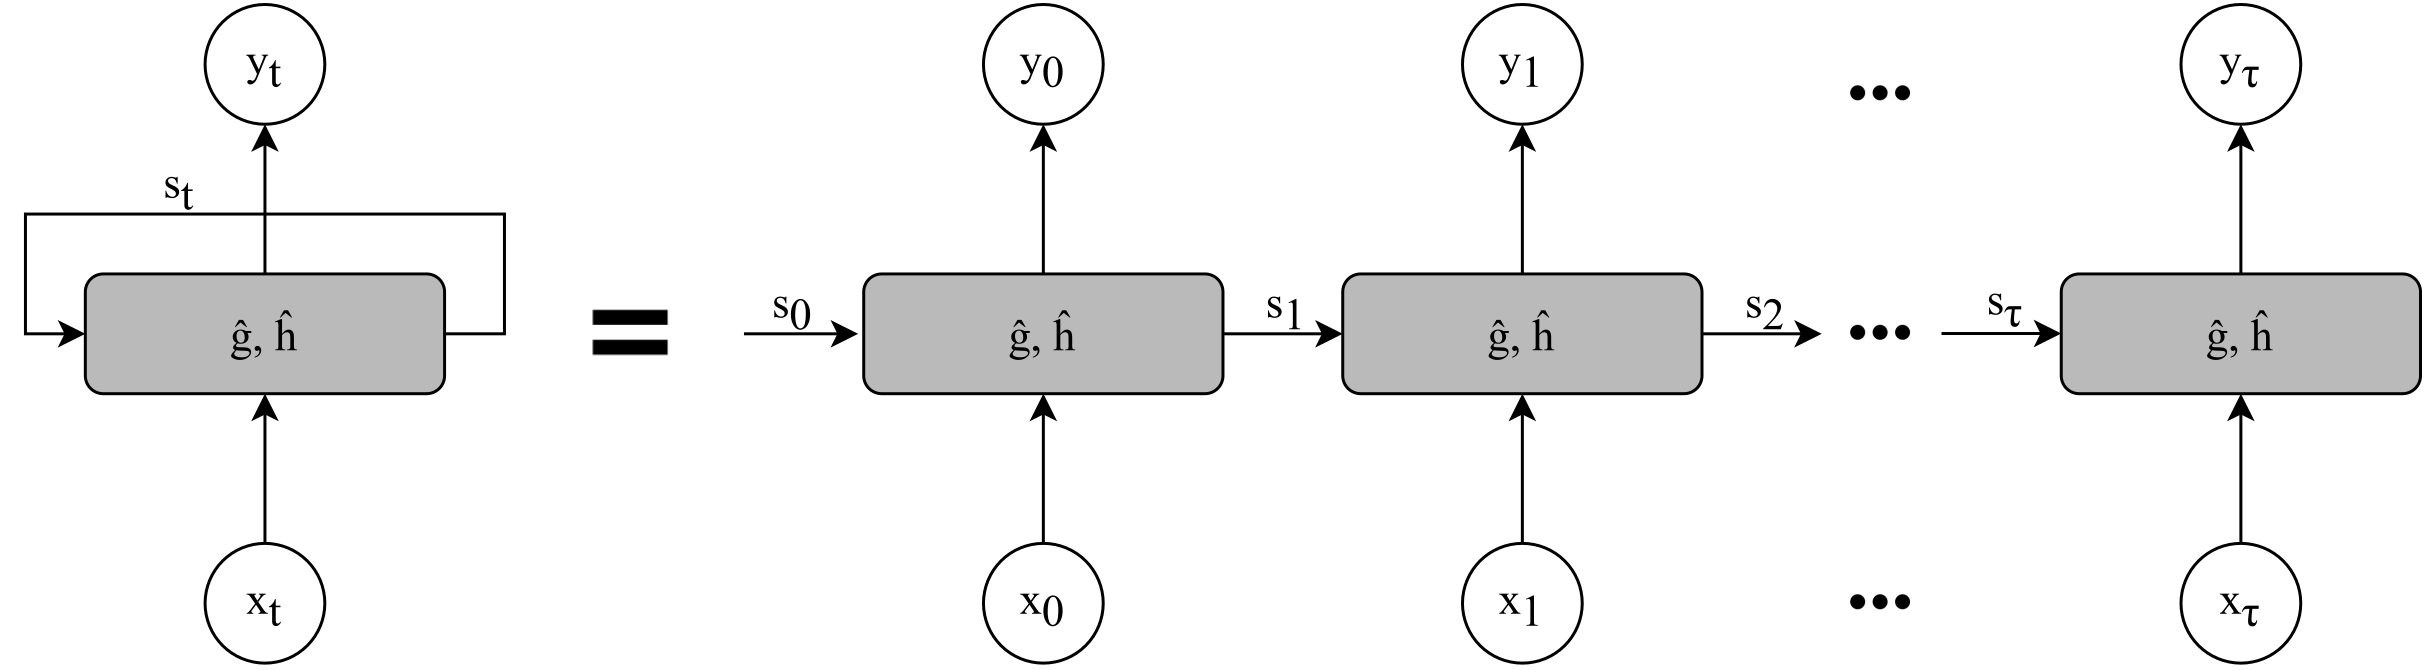

The input sequence is denoted as $x_0, x_1, \dots, x_{\tau}$. The gray block containing the functions $\hat{g}$ and $\hat{h}$ is a neural network that takes two things as input:


1.   An element $x_t$ of the sequence
2.   A state $s_t$

Based on this input, it outputs a prediction $y_t$. We apply this block to every element of the sequence in order. The state $s_t$ is used to encode all necessary information of the input $x_0, \dots, x_{t-1}$ when we make the prediction for $x_t$. In the beginning, we initialize the state $s_0$ by setting it to all zeros. This state is then passed to the network, together with $x_0$. We then get the prediction $y_0$ and the state $s_1$ that is used for the subsequent evaluation of the same network for the next element in the input sequence $x_1$. This is what we see on the right of the image. Note that all gray blocks are the same network. We just run it again and again (recurrently). The length of the sequence can therefore be arbitrary.



There are several ways to implement the gray block. We will use Long short-term memory (LSTM) units in the upcoming task. Similar in concept to n-grams, we predict the next word in the sequence based on what we saw before. These predictions are exactly the $y_i$. More precisely, our prediction is a probability distribution over the whole vocabulary, telling us which words are the most likely to follow.   

We work with the brown corpus again, so let's make sure it's ready.

In [37]:
import nltk
from nltk.corpus import brown
nltk.download('brown')
import torch

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Training on the whole corpus would take too long for this tutorial, so we restrict ourselves to the first 200,000 words.

In [38]:
corpus = [word for request in tokenized_data for word in request]

The inputs $x_i$ naturally represent the words in our corpus. We start with a simple embedding and pass a word index for $x_i$ (similar to the indices we looked at for BERT before, only that the tokenization is already done for us).
Therefore, we want a mapping from words in the vocabulary to indices in `[0, len(vocabulary)-1]` and the reverse mapping from indices to words.

In [39]:
unique_words = list(set(corpus))
unique_words.sort()
index_to_word = {index: word for index, word in enumerate(unique_words)}
word_to_index = {word: index for index, word in enumerate(unique_words)}


We can do a small sanity check for the mapping:

In [40]:
print(word_to_index['the'])
print(word_to_index['password'])
print(index_to_word[word_to_index['the']])

15731
11937
the


Next, we are going to build the dataset that we train with. We take sequences from the corpus that we can then pass to the model and define our training target `y` as the next word in the sequence. In the end, we train the model by letting it predict the next word in the sequence that followed in the original corpus. Here is how this should look like:

```
x[0] =  [2708, 7862, 8167, 14159, 751]
y[0] =  [7862, 8167, 14159, 751, 3115]
```
As you can see, every training datapoint should contain a sequence of word indices and a shifted version for the output.

In [41]:
from torch.utils.data import TensorDataset, DataLoader

# Create the training dataset
sequence_length = 5
x, y = [], []

for i in range(0, len(corpus) - sequence_length):
  # TODO: Append the right sequences.
  x.append([word_to_index[w] for w in corpus[i:i+sequence_length]])
  y.append([word_to_index[w] for w in corpus[i+1:i+sequence_length+1]])

# Create a dataloader, this enables us to easily batch data
data = TensorDataset(torch.tensor(x), torch.tensor(y))
data_loader = DataLoader(data, shuffle=True, batch_size=256)

Once this works, we can continue with defining the model!

In [42]:
import torch

class RNN(torch.nn.Module):
  def __init__(self, vocab_size, output_size, lstm_size, embedding_dim, num_layers):
    super(RNN, self).__init__()
    # Setup some parameters
    self.lstm_size = lstm_size
    self.embedding_dim = embedding_dim
    self.num_layers = num_layers

    # Map the vocabulary indices to a small dimensional embedding
    self.embedding = torch.nn.Embedding(
        num_embeddings=vocab_size,
        embedding_dim=self.embedding_dim
    )

    # This is the main building block we use; we just have to pass some parameters
    self.lstm = torch.nn.LSTM(
        input_size=self.embedding_dim,
        hidden_size=self.lstm_size,
        num_layers=self.num_layers,
        batch_first=True,
        dropout=0.2
    )

    # We apply a fully connected layer to get the desired output size
    self.fc = torch.nn.Linear(self.lstm_size, output_size)

  def forward(self, x, previous_state):
    # Get the embedding from the input word index
    embed = self.embedding(x)

    # Apply the LSTM block to it
    output, state = self.lstm(embed, previous_state)

    # Apply the fully connected layer and get "logits"
    # logits is an output from a network that is not activated,
    # i.e. did not pass an activation layer at the end
    logits = self.fc(output)

    return logits, state

  # Get the initial zero state
  # The state of an LSTM is split into two: One part that represents long-term and one part that represents short-term memory
  def get_initial_state(self, batch_size):
    return (torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device), torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device))


To make the training fast enough, we will have to do it on the GPU. Do not worry as pytorch makes this extremely easy for us. Some of you may recall that we already did that in the introduction.

#### Intermezzo: Running with pytorch on the GPU

First, you need to get a GPU to run on. Navigate to the `Runtime` tab and select `Change runtime type` in google colab. A small window opens, and you can select `GPU` from the dropdown list. Then click on `Save`. Because the type of the runtime has changed, you will have to restart the kernel, and make sure to run the necessary cells again afterward. Once you have done this, the next cell should tell you that you have a `cuda` device available.

In [43]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


To run our code on the GPU, we must ensure that our tensors are on the right device. Pytorch will then automatically use the device on which the tensors used in the computation are located. You can set the location for a tensor when you create it or move it to a device afterward.


In [44]:
tensor1 = torch.tensor([1, 2, 3], device=device)
print(f"tensor1 is on GPU: {tensor1.is_cuda}")
tensor2 = torch.tensor([4, 5, 6])
print(f"tensor2 is on GPU: {tensor2.is_cuda}")
tensor2 = tensor2.to(device)
print(f"tensor2 is on GPU: {tensor2.is_cuda}")

tensor1 is on GPU: True
tensor2 is on GPU: False
tensor2 is on GPU: True


Both tensors should be on the GPU now, and if we do a computation with them it will take place on the GPU and write the output to the same device they are on:

In [45]:
tensor1 + tensor2

tensor([5, 7, 9], device='cuda:0')

If the tensors are not on the same device, pytorch will complain:

You can not just move tensors, but also whole models to another device:

In [46]:
model = RNN(vocab_size = len(unique_words), output_size=len(unique_words), lstm_size=256, embedding_dim=128, num_layers=2).to(device)

That's it, this is all you need to know to run models on the GPU!

#### Running the LSTM

Now that you know how to execute code on other devices, change the train function to run on the GPU! If you don't do this, you will not be able to train a good model in the next few hours.
Afterward, we can finally train.

In [47]:
from torch import optim

# TODO: Move tensors to the right device
def train(model, data_loader):
  model.train()

  initial_state = model.get_initial_state(256)

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.01)

  for epoch in range(10):
    loss_total = 0
    for batch, (x, y) in enumerate(data_loader):
      if x.shape[0] != 256:
        continue

      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()

      y_pred, _ = model(x, initial_state)
      loss = criterion(y_pred.transpose(1, 2), y)

      loss.backward()
      optimizer.step()

      loss_total += loss.item()

    print(f"epoch: {epoch}, loss: {loss_total / batch}")

Now we are able to train!

In [48]:
model = RNN(vocab_size = len(unique_words), output_size=len(unique_words), lstm_size=256, embedding_dim=128, num_layers=1).to(device)
train(model, data_loader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch: 0, loss: 3.819004206050024
epoch: 1, loss: 3.2096532362369192
epoch: 2, loss: 3.048221781886837
epoch: 3, loss: 2.9682981468016103
epoch: 4, loss: 2.921225843595216
epoch: 5, loss: 2.889825416557842
epoch: 6, loss: 2.869441918739117
epoch: 7, loss: 2.8554107580823875
epoch: 8, loss: 2.843177141681794
epoch: 9, loss: 2.835503826168966


After the training is finished, we can generate new sentences.

In [49]:
import numpy as np

def predict(model, seed, next_words=20):
    # Tokenize the seed text
    words = seed.split(' ')
    # Activate evaluation mode on model (deactivate specific functions like dropout)
    model.eval()

    # Get the initial zero state, we will run with a batch size of 1
    state_h, state_c = model.get_initial_state(1)

    # Get the first prediction and hidden state for the initial word sequence
    x = torch.tensor([[word_to_index[w] for w in words]], device=device)
    y_pred, (state_h, state_c) = model(x, (state_h, state_c))

    for i in range(0, next_words):
        # Get the output after the last element in the sequence
        last_word_logits = y_pred[0][-1]

        # Apply softmax to get probabilites from logits
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()

        # Sample the index for the next random word
        word_index = np.random.choice(len(last_word_logits), p=p)

        # Append it to the generated text
        words.append(index_to_word[word_index])

        # Use the previous hidden state and the new word to make the next prediction
        y_pred, (state_h, state_c) = model(torch.tensor([[word_index]], device=device), (state_h, state_c))

    return words

Let's see it in action, we start with some seed text and let the model continue it.

In [50]:
print(predict(model, seed='can you', next_words=30))

['can', 'you', 'give', 'the', 'product', 'what', 'time', 'someone', 'sends', 'an', 'external', 'email', 'to', 'study', 'the', 'project', '.', 'write', 'a', 'description', 'of', 'a', 'computer', 'scientist', 'app', '.', 'name', 'five', 'items', 'that', 'would', 'help']


#### Exercise 1b

In [51]:
#tokenized_corpus = [nltk.tokenize.word_tokenize(w) for w in corpus]
my_word2vec = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4)

# train(my_word2vec, data_loader)
# my_word2vec.train(data_loader, total_examples=len(corpus), epochs=10)

Utilize the Word2Vec model trained in the previous exercise instead of employing `torch.nn.Embedding` to map word indices to lower-dimensional embeddings. For example, you could pass the trained Word2Vec model to the RNN in the constructor for later use.

In [52]:
# Same class as the RNN from before
class Word2VecRNN(torch.nn.Module):
  def __init__(self, w2v_model, output_size, lstm_size, embedding_dim, num_layers):
    super(Word2VecRNN, self).__init__()
    # Setup some parameters
    self.lstm_size = lstm_size
    self.embedding_dim = embedding_dim
    self.num_layers = num_layers

    # Map the vocabulary indices to a small dimensional embedding
    #self.embedding = torch.nn.Embedding(
    #    num_embeddings=vocab_size,
    #    embedding_dim=self.embedding_dim
    #)

    self.w2v_model = w2v_model

    # This is the main building block we use; we just have to pass some parameters
    self.lstm = torch.nn.LSTM(
        input_size=self.w2v_model.vector_size,
        hidden_size=self.lstm_size,
        num_layers=self.num_layers,
        batch_first=True,
        dropout=0.2
    )

    # We apply a fully connected layer to get the desired output size
    self.fc = torch.nn.Linear(self.lstm_size, output_size)

  def forward(self, x, previous_state):
    # Get the embedding from the input word index
    embed = torch.tensor([self.w2v_model.wv[word] for word in x], device=device)

    # Apply the LSTM block to it
    output, state = self.lstm(embed, previous_state)

    # Apply the fully connected layer and get "logits"
    # logits is an output from a network that is not activated,
    # i.e. did not pass an activation layer at the end
    logits = self.fc(output)

    return logits, state

  # Get the initial zero state
  # The state of an LSTM is split into two: One part that represents long-term and one part that represents short-term memory
  def get_initial_state(self, batch_size):
    return (torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device), torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device))

In [53]:
model = Word2VecRNN(w2v_model=my_word2vec, output_size=len(unique_words), lstm_size=256, embedding_dim=128, num_layers=1).to(device)
train(model, data_loader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


KeyError: "Key '6552' not present"

In [54]:
print(predict(model, seed='can you', next_words=30))

KeyError: "Key '3977' not present"

#### Exercise 2

Instead of `torch.nn.LSTM` for the recurrent neural network, use `torch.nn.GRU`. Does one of them work better than the other?

In [55]:
class GRURNN(torch.nn.Module):
  def __init__(self, vocab_size, output_size, lstm_size, embedding_dim, num_layers):
    super(GRURNN, self).__init__()
    # Setup some parameters
    self.lstm_size = lstm_size
    self.embedding_dim = embedding_dim
    self.num_layers = num_layers

    # Map the vocabulary indices to a small dimensional embedding
    self.embedding = torch.nn.Embedding(
        num_embeddings=vocab_size,
        embedding_dim=self.embedding_dim
    )

    # This is the main building block we use; we just have to pass some parameters
    self.gru = torch.nn.GRU(
        input_size=self.embedding_dim,
        hidden_size=self.lstm_size,
        num_layers=self.num_layers,
        batch_first=True,
        dropout=0.2
    )

    # We apply a fully connected layer to get the desired output size
    self.fc = torch.nn.Linear(self.lstm_size, output_size)

  def forward(self, x, previous_state):
    # Get the embedding from the input word index
    embed = self.embedding(x)

    # Apply the GRU block to it
    output, state = self.gru(embed, previous_state)

    # Apply the fully connected layer and get "logits"
    logits = self.fc(output)

    return logits, state

  # Get the initial zero state
  def get_initial_state(self, batch_size):
    return torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device)


In [56]:
model = GRURNN(vocab_size = len(unique_words), output_size=len(unique_words), lstm_size=256, embedding_dim=128, num_layers=1).to(device)
train(model, data_loader)

epoch: 0, loss: 3.9021587071091406
epoch: 1, loss: 3.3100720024779378
epoch: 2, loss: 3.146212274028409
epoch: 3, loss: 3.065718698639629
epoch: 4, loss: 3.0182780359676795
epoch: 5, loss: 2.9863365387699643
epoch: 6, loss: 2.965533883143694
epoch: 7, loss: 2.9493622529398222
epoch: 8, loss: 2.9380717591079826
epoch: 9, loss: 2.928351093659823


In [57]:
import numpy as np

def predictGRU(model, seed, next_words=20):
    # Tokenize the seed text
    words = seed.split(' ')
    # Activate evaluation mode on model (deactivate specific functions like dropout)
    model.eval()

    # Get the initial zero state, we will run with a batch size of 1
    state = model.get_initial_state(1)

    # Get the first prediction and hidden state for the initial word sequence
    x = torch.tensor([[word_to_index[w] for w in words]], device=device)
    y_pred, state = model(x, state)

    for i in range(0, next_words):
        # Get the output after the last element in the sequence
        last_word_logits = y_pred[0][-1]

        # Apply softmax to get probabilites from logits
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()

        # Sample the index for the next random word
        word_index = np.random.choice(len(last_word_logits), p=p)

        # Append it to the generated text
        words.append(index_to_word[word_index])

        # Use the previous hidden state and the new word to make the next prediction
        y_pred, state = model(torch.tensor([[word_index]], device=device), state)

    return words

print(predictGRU(model, seed='can you', next_words=30))

['can', 'you', 'improve', 'the', 'user', 'and', 'describe', 'the', 'structure', 'of', 'a', 'website', '.', 'explain', 'solar', 'in', 'a', 'more', 'positive', '.', 'edit', 'the', 'following', 'sentence', '.', 'given', 'the', 'given', 'sentence', '.', 'what', 'is']


## Sentiment analysis

Previously we looked at auto-regressive text generation. For that, we used the output after the last element of the sequence and predicted the next word. It was a classification problem where we had one class per word in the vocabulary. Next, we want to look at a slightly different classification problem, binary sentiment analysis. Given a review from the IMDB website, we want to predict if the reviewer gave a positive or negative review. In contrast to our previous problem, where we used "unsupervised" methods (i.e., no labels were given), we now have labeled data.

Let's start by loading the dataset. This time we use the `datasets` and `transformers` library from Huggingface.

In [58]:
%%capture
!pip install datasets
!pip install accelerate --upgrade
!pip install transformers

In [59]:
import torch
from datasets import load_dataset

In [61]:
imdb = load_dataset('imdb')

TypeError: http_get() got an unexpected keyword argument 'displayed_filename'

Everything was downloaded for us, now we can look at the structure of the dataset.

In [62]:
from sklearn.model_selection import train_test_split
df_type = pd.read_csv("/content/requests_mapped_to_keywords.csv")
train_df, test_df = train_test_split(df_type, test_size=0.5, random_state=42)  # Adjust test_size as needed

The dataset is already split into three parts. We will use the `train` and `test` dataset for training and testing our model respectively. Also, we now have labels that tell us if a review is positive or negative. Let's have a look at the first datapoint.

In [ ]:
imdb['train'][0]

There is quite some text and a label at the end, in this case `0`, meaning that the review was negative. This time we will use the BertTokenizer we presented before and download the pretrained version again.

In [63]:
%%capture
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Now it's time to create the dataset. We want to have tokenized text and its corresponding label.

In [86]:
# Encode your own dataset
x_train, y_train = [], []
label_to_id = {
    'The lazy Googler': 0,
    'The lazy creater': 1,
    'The lazy Editor': 2,
    'Other': 3
}

for i in range(len(train_df)):
    encoded_text = tokenizer.encode(train_df['request'].iloc[i], padding='max_length', max_length=200, truncation=True)
    x_train.append(encoded_text)
    y_train.append(label_to_id[train_df['request_type'].iloc[i]])  # Use label ID from mapping

# Convert lists to tensors for train set
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)

# Create a TensorDataset for train set
train_data = TensorDataset(x_train_tensor, y_train_tensor)

# Create a DataLoader for train set
train_loader = DataLoader(train_data, shuffle=True, batch_size=16)

# Encode your test dataset
x_test, y_test = [], []
for i in range(len(test_df)):
    encoded_text = tokenizer.encode(test_df['request'].iloc[i], padding='max_length', max_length=200, truncation=True)
    x_test.append(encoded_text)
    y_test.append(label_to_id[test_df['request_type'].iloc[i]])  # Use label ID from mapping

# Convert lists to tensors for test set
x_test_tensor = torch.tensor(x_test).to(device)
y_test_tensor = torch.tensor(y_test).to(device)

# Create a TensorDataset for test set
test_data = TensorDataset(x_test_tensor, y_test_tensor)

# Create a DataLoader for test set
test_loader = DataLoader(test_data, shuffle=False, batch_size=16)
#data_loader = [(x.to(device), y.to(device)) for x, y in test_loader]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Notice that when encoding the text, we use padding and truncation. This is because we want all our inputs to have the same size, irrespective of the original review text length. It is technically not completely necessary for the RNN that we will use, but afterward, we will look at another architecture, transformers, that need this. It also makes batching easier (as all elements have the same size).

So how do we achieve this?

When the text is too long, we use truncation and cut off the last words to make it at most `max_length` long. If the text is too short, we add some special padding tokens (these have index 0, check the first word in the vocabulary of the BERT tokenizer that we printed before) to make it fit. The output then looks like this:

In [80]:
print(test_data[0])

(tensor([ 101, 9699, 1037, 2862, 1997, 7832, 2005, 1037, 8835, 2006, 2974, 1012,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  

For training, we can basically take the same function as before, the only thing that has to be changed is the loss calculation. Now, the label y is just one class and we only want to backpropagate from the last output we got.

In [81]:
from torch import optim

def train(model, data_loader):
  model.train()

  initial_state = model.get_initial_state(16)

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  for epoch in range(10):
    loss_total = 0
    for batch, (x, y) in enumerate(data_loader):
      if x.shape[0] != 16:
        continue
      optimizer.zero_grad()

      x = x.to(device)
      y = y.to(device)

      y_pred, _ = model(x, initial_state)

      loss = criterion(y_pred.transpose(0,1)[-1], y)

      loss.backward()
      optimizer.step()

      loss_total += loss.item()

    print(f"epoch: {epoch}, loss: {loss_total / batch}")

For the model, we can use exactly the same RNN as before, here is the code again in case you did some changes to the cell where it was defined before:

In [82]:
import torch

class RNN(torch.nn.Module):
  def __init__(self, vocab_size, output_size, lstm_size, embedding_dim, num_layers):
    super(RNN, self).__init__()
    # Setup some parameters
    self.lstm_size = lstm_size
    self.embedding_dim = embedding_dim
    self.num_layers = num_layers

    # Map the vocabulary indices to a small dimensional embedding
    self.embedding = torch.nn.Embedding(
        num_embeddings=vocab_size,
        embedding_dim=self.embedding_dim
    )

    # This is the main building block we use; we just have to pass some parameters
    self.lstm = torch.nn.LSTM(
        input_size=self.lstm_size,
        hidden_size=self.lstm_size,
        num_layers=self.num_layers,
        batch_first=True,
        dropout=0.2
    )

    # We apply a fully connected layer to get the desired output size
    self.fc = torch.nn.Linear(self.lstm_size, output_size)

  def forward(self, x, previous_state):
    # Get the embedding from the input word index
    embed = self.embedding(x)

    # Apply the LSTM block to it
    output, state = self.lstm(embed, previous_state)

    # Apply the fully connected layer and get "logits"
    # logits is an output from a network that is not activated,
    # i.e. did not pass an activation layer at the end
    logits = self.fc(output)

    return logits, state

  # Get the initial zero state
  # The state of an LSTM is split into two: One part that represents long-term and one part that represents short-term memory
  def get_initial_state(self, batch_size):
    return (torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device), torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device))


Finally, we can train it.

In [83]:
print(len(tokenizer.vocab))
model = RNN(vocab_size = len(tokenizer.vocab), output_size=2, lstm_size=128, embedding_dim=128, num_layers=2).to(device)
train(model, data_loader)

30522


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


To see if it actually works, we can look at the test dataset. This was not used during training, so it contains reviews that the model has never seen before. What is sentiment of this review?

In [75]:
train_df['request'].iloc[1]

'Generate a set of alternative words to replace the given word.'

Let's look at what our model thinks.

In [76]:
model.eval()
input = torch.tensor([tokenizer.encode(train_df['request'].iloc[1], padding='max_length', max_length=200, truncation=True)], device=device)
# Batch size is 1
initial_state = model.get_initial_state(1)
y_pred, _ = model(input, initial_state)

In [78]:
# softmax over the output gives us the class probabilities
torch.nn.functional.softmax(y_pred[0][-1], dim=0).detach().cpu().numpy()[1]

0.522157

This is the real label (0 for a bad review and 1 for a good review).

In [ ]:
imdb['test'][0]['label']

Of course, only looking at one prediction does not tell us too much. To really estimate the quality of our sentiment analyser, we should compute a score over datapoints in the test dataset!

In [ ]:
x_test, y_test = [], []

# We take 200 datapoints from the test dataset
for i in range(200):
  x_test.append(torch.tensor(tokenizer.encode(imdb['test'][i]['text'], padding='max_length', max_length=200, truncation=True)))
  y_test.append(imdb['test'][i]['label'])

In [ ]:
# TODO: Compute the accuracy of the predictor
# The accuracy is the percentage of correct predictions
is_corr = 0
initial_state = model.get_initial_state(1)  # Set batch size to 1
# Run the model to get the prediction for x_test[i] and compare it to the label y_test[i]
for i in range(len(x_test)):
  # Add an extra dimension for batch size and ensure x_test is on the same device as the model
  x_test[i] = x_test[i].unsqueeze(0).to(device)
  y_pred, _ = model(x_test[i], initial_state)
  if y_test[i] == 1 - round(torch.nn.functional.softmax(y_pred[0][-1], dim=0).detach().cpu().numpy()[0]):
    is_corr += 1

# Aggregate the results
accuracy = is_corr / len(x_test)
accuracy_percentage = accuracy * 100
accuracy_percentage

### Exercise

Run with the GRU variant that you implemented before and check if you can improve the accuracy.

In [ ]:
model = GRURNN(vocab_size = len(tokenizer.vocab), output_size=2, lstm_size=128, embedding_dim=128, num_layers=2).to(device)
train(model, data_loader)

model.eval()

x_test, y_test = [], []

# We take 200 datapoints from the test dataset
for i in range(200):
  x_test.append(torch.tensor(tokenizer.encode(imdb['test'][i]['text'], padding='max_length', max_length=200, truncation=True)))
  y_test.append(imdb['test'][i]['label'])

  # The accuracy is the percentage of correct predictions
is_corr = 0
initial_state = model.get_initial_state(1)  # Set batch size to 1
# Run the model to get the prediction for x_test[i] and compare it to the label y_test[i]
for i in range(len(x_test)):
  # Add an extra dimension for batch size and ensure x_test is on the same device as the model
  x_test[i] = x_test[i].unsqueeze(0).to(device)
  y_pred, _ = model(x_test[i], initial_state)
  if y_test[i] == 1 - round(torch.nn.functional.softmax(y_pred[0][-1], dim=0).detach().cpu().numpy()[0]):
    is_corr += 1

# Aggregate the results
accuracyGRU = is_corr / len(x_test)
accuracyGRU_percentage = accuracyGRU * 100
accuracyGRU_percentage

## Pretrained models

Until now, we created our own models using some building blocks from pytorch like the the LSTM module. The RNN was already capable of getting some decent predictions. Nowadays, another architecture is predominantly used for almost all NLP tasks. It is called "Transformer" and the main difference to RNNs is that instead of sequentially processing the input sequence, it uses an "attention" mechanism to process all elements in the sequence at once. Every element can "attend" to every other element, meaning it knows approximately where it is located in the sequence and what other elements are. We omit further details here. There are a lot of good tutorials online that you can check out to get a more profound introduction to how transformers work under the hood. For us, they are just a building block (or black box) that we can use to get predictions. We already talked about one transformer: BERT (Bidirectional Encoder Representations from Transformers).

The Huggingface libraries already provide pretrained transformers for a wide range of tasks. Furthermore, they are straightforward to use and deploy. Let's look at one for sentiment analysis and test it on the IMDB dataset again.

In [ ]:
%%capture
!pip install datasets
!pip install accelerate --upgrade
!pip install transformers

In [ ]:
import torch
from datasets import load_dataset

In [ ]:
imdb = load_dataset('imdb')

Until here, we just did the usual imports, here is where the real magic happens:

In [ ]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis')

Believe it or not, this is doing everything for us. Deciding what model to use, downloading it and setting up the complete pipeline including tokenization. Now we can just use it, for example on the first datapoint from the test dataset:

In [ ]:
classifier(imdb['test'][0]['text'])

Exercise: What is the accuracy of the whole test dataset?

In [ ]:
# Function to calculate accuracy
def calculate_accuracy(predictions, labels):
  # We assume that the labels are 0 or 1
  correct = 0
  for i in range(len(predictions)):
    if predictions[i]['label'] == 'POSITIVE' and labels[i] == 1:
      correct += 1
    elif predictions[i]['label'] == 'NEGATIVE' and labels[i] == 0:
      correct += 1
  return correct / len(predictions)

Similar to RNNs, transformers can be used for a wide range of tasks. Another example is text summarization (for a full list of tasks, check out [this website](https://huggingface.co/docs/transformers/main/en/quicktour)).

In [ ]:
summarizer = pipeline('summarization')

In [ ]:
print("original text:\n")
print(imdb['test'][0]['text'])
print("summary: ")
summarizer(imdb['test'][0]['text'])

Another classic task is translation. Again, we could also do this with RNNs, for example by using the output of every element in the sequence to translate the words. Again, Huggingface provides some pretrained models.

In [ ]:
classifier = pipeline('translation_en_to_de')

In [ ]:
classifier('HODL is the best course at ETH.')

(Btw., irony detection is also an active research area in NLP.)

A bit of a different task is question answering. Here, we have to give some context that can be used to answer the question.

In [ ]:
qa = pipeline('question-answering')

In [ ]:
qa(context="ETH is a university located in Zürich. Zürich is the biggest city of Switzerland.", question="What country is ETH located in?")

### Exercise

We just saw several models for different tasks that we can just use out of the box. What if we want to combine these models to create something even more powerful? Use two pipelines to create German (or another foreign language if you like to) summaries for English texts, for example of an IMDB review.

In [ ]:
#somehow the classifier doesn't translate anymore but this would work
# transL = pipeline('translation_en_to_de')
# summ = pipeline('summarization')
def german_summary(text):
  # TODO
  #print(text)
  shorted = summarizer(text, max_length=80)[0]['summary_text']
  summary = classifier(shorted, max_length=500)[0]['translation_text']
  #print(to_german)
  return summary

german_summary(imdb['test'][0]['text'])

## Finetuning

Using pretrained models is easy, and we don't have to do more complicated engineering work to run them. However, these models were pretrained on a very general corpus that might need to be more suitable for the task we have at hand. We, therefore, want to improve ("finetune") this model to include more domain-specific knowledge. We can do this by training the pretrained model on more data samples from our task. In this section, we will do precisely this.

We will use a "distilled" version of BERT: `distilbert`. Here, distilled means that researchers started with a fully trained BERT model and reduced its size by changing the network architecture without impacting performance too much. The distilled model is, therefore, smaller and easier for us to train.

Let's load the tokenizer first and preprocess the dataset.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
def preprocess_function(examples):
  return tokenizer(examples["text"], truncation=True, padding=True, return_tensors='pt')

In [ ]:
tokenized_imdb = imdb.map(preprocess_function, batched=True)

We directly applied the preprocess function, thus tokenizing all of the input sentences. Now it's time to load the model.

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Because training would take too long on the full dataset, we only do it on a subset.

In [ ]:
train_dataset = tokenized_imdb['train'].shuffle(seed=0).select(range(1000))
test_dataset = tokenized_imdb['test'].shuffle(seed=0).select(range(2000))

To run with the `Trainer` class that is provided by Huggingface, we have to define a trainig configuration first. These are basically the same parameters we used in out train loops before.

In [ ]:
!pip install accelerate -U
!pip install transformers[torch]
import accelerate
import transformers

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy='epoch'
)

Huggingface also provides metrics, we are going to use accuracy, but others are possible too.

In [ ]:
!pip install evaluate
import numpy as np
import evaluate

metric = evaluate.load('accuracy')

In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

And after defining the trainer by passing all the necessary input, ...

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

we can train the model with a simple call.

In [ ]:
trainer.train()

Now it's your turn, optimize the accuracy and send us your code for the chance of getting some sweet chocolate!

## Challenge submission

The following cell should run independently (even after the notebook kernel was restarted) and produce the scores for your challenge submission. We only take sumbissions into consideration that run inside this cell! A baseline solution achives around 90% accuracy.

In [ ]:
#had to add this
!pip install scikit-learn
!pip install accelerate -U
!pip install transformers[torch]
!pip accelerate --upgrade
import accelerate
#I know that this is too much but I kept receiving the error message

!pip install datasets
!pip install accelerate --upgrade
!pip install transformers
!pip install evaluate
import numpy as np
import evaluate
from transformers import AutoTokenizer
from datasets import load_dataset
imdb = load_dataset('imdb')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def preprocess_function(examples):
  return tokenizer(examples["text"], truncation=True, padding=True, return_tensors='pt')

tokenized_imdb = imdb.map(preprocess_function, batched=True)
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig
config = AutoConfig.from_pretrained("distilbert-base-uncased", num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)
# model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
train_dataset = tokenized_imdb['train'].shuffle(seed=0).select(range(1000))

# Do not change the test dataset, this is what your score will be based on!
test_dataset = tokenized_imdb['test'].shuffle(seed=0).select(range(2000))

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    #evaluation_strategy='epoch'
    evaluation_strategy='steps',
    eval_steps=100,  # Adjust this value
    save_total_limit=3,  # Limit the number of checkpoints saved
    load_best_model_at_end=True,
)

metric = evaluate.load('accuracy')

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

## Further resources


*   [https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html)
*   [https://github.com/nlptown/nlp-notebooks](https://github.com/nlptown/nlp-notebooks)
*   [https://machinelearningmastery.com/what-are-word-embeddings/](https://machinelearningmastery.com/what-are-word-embeddings/)
*   [https://github.com/google-research/bert](https://github.com/google-research/bert)
*   [https://github.com/bentrevett/pytorch-sentiment-analysis](https://github.com/bentrevett/pytorch-sentiment-analysis)
*   [https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb#scrollTo=YOCrQwPoIrJG](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb#scrollTo=YOCrQwPoIrJG)
*   [https://huggingface.co/docs/transformers/main/en/quicktour](https://huggingface.co/docs/transformers/main/en/quicktour)

